Importing python libraries

In [22]:
import sqlalchemy
import psycopg2 as ps
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# PostgreSQL IMPLEMENTATION

To create a connection between jupyter notebook and postgres

In [13]:
conn2 = ps.connect(dbname = "postgres", user = "ag_class", password = "WUcgdfQ1", host = "awesome-hw.sdsc.edu", port = "5432")

## patentdb

Finding the number of patents under each technology 

In [ ]:
#Original query extracting technology word and it's company
sql = """with b as
(with a as
(select translate(classname, '[{][}]', '') as classname
from "patentdb (1)"
where classname is not null)
select classname,
(string_to_array(classname, ';'))[1] as first_word
          from a
    ),
c as (
select patentid, assignee_name_current from "patentdb (1)" where classname is not null
)
select (string_to_array(first_word, ','))[1] as techword,patentid, translate(assignee_name_current,'{}','') as currentCompany
from b,c;"""
df = sqlio.read_sql_query(sql,conn2)

In [47]:
#optimised sql query and making the connection between postgres and jupyter
sql = """select  (string_to_array((string_to_array(translate(classname, '[{][}]', ''), ';'))[1], ','))[1] as techword,
patentid, translate(assignee_name_current,'{}','') as currentCompany from "patentdb (1)"
"""
df = sqlio.read_sql_query(sql,conn2)

In [16]:
#dropping all the null value columns
df = df[df["techword"].notna()]


In [17]:
#grouping the dataframe with techword to create a series which is again converted to dataframe
d = df.groupby('techword')['patentid'].nunique()
d= d.to_frame()

In [18]:
#removing unwanted rows and adding the techword column
r = d[d.patentid != 113]
dataframe = r
techword = ['CHEMISTRY', 'ELECTRICITY', 'FIXED CONSTRUCTIONS', 'HUMAN NECESSITIES', 'MECHANICAL ENGINEERING', 'PERFORMING OPERATIONS','PHYSICS','TEXTILES']
dataframe['techword'] = techword


C:\Users\tejon\AppData\Local\Temp/ipykernel_13044/3464397834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['techword'] = techword


In [19]:
dfN = dataframe[['patentid','techword']]
dfN

,patentid,techword
techword,,
CHEMISTRY,2083,CHEMISTRY
ELECTRICITY,5315,ELECTRICITY
FIXED CONSTRUCTIONS,202,FIXED CONSTRUCTIONS
HUMAN NECESSITIES,495,HUMAN NECESSITIES
MECHANICAL ENGINEERING,5000,MECHANICAL ENGINEERING
PERFORMING OPERATIONS,3446,PERFORMING OPERATIONS
PHYSICS,6594,PHYSICS
TEXTILES,176,TEXTILES


<AxesSubplot:xlabel='techword'>

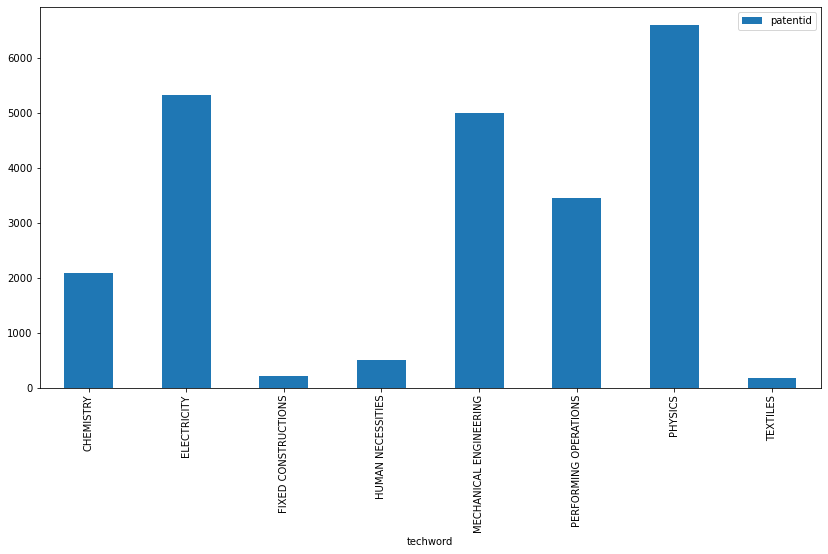

In [20]:
#plotting the dataframe
dfN.plot(x="techword", y="patentid", kind="bar", figsize = (14,7))

## sbir_award_data

In [38]:
#Visualization of how the award amount changes over the years

sql = """with a as (
select sum(award_amount) as sum, award_year, company
           from "NewResult"
           GROUP BY company, award_year),

    trend_line as(
        select slope,
               y_max - x_max * slope as intercept
        from(
            select
                coalesce((nullif(sum((award_year-x_bar)*(sum-y_bar)),0)/nullif(sum((award_year-x_bar)*(award_year-x_bar)),0)),0) as slope,
                max(x_bar) as x_max,
                max(y_bar) as y_max
            from(
                select award_year, avg(award_year) over() as x_bar,
                       sum, avg(sum) over() as y_bar
                from a
                )data1
            )data2
    )
select a.*,
       (a.award_year * (select slope from trend_line)+(select intercept from trend_line)) as trend_line
from a;"""
df = sqlio.read_sql_query(sql,conn2)


In [39]:
df = sqlio.read_sql_query(sql,conn2)

In [40]:
df.head(5)

,sum,award_year,company,trend_line
0,1095042.0,1995,"Sparta, Inc.",329746.742573
1,693085.0,1992,Electro-optek Corp,317740.800289
2,59613.0,1995,Frontier Technology Inc.,329746.742573
3,735490.0,1997,"ELO TECHNOLOGIES, INC.",337750.704096
4,150000.0,2016,APPLIED NOVEL DEVICES INC,413788.338563


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'scatter chart')

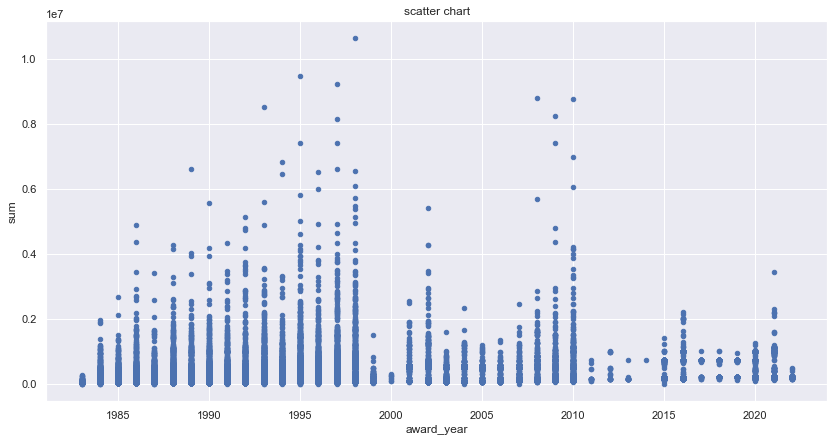

In [41]:
df.plot(x="award_year", y="sum", kind="scatter",figsize = (14,7))
plt.title("scatter chart")

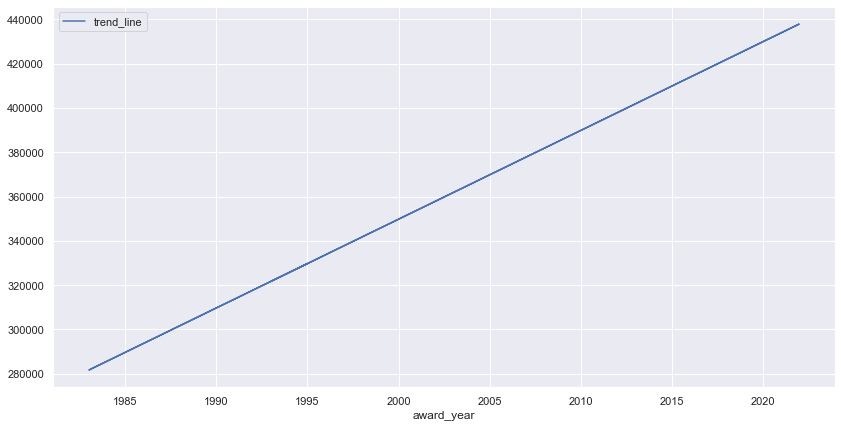

In [46]:
df.plot(x="award_year",y="trend_line",kind="line",figsize = (14,7))
plt.show()

# NEO4J IMPLEMENTATION

In [33]:
#connecting jupyter notebook to neo4j browser
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "pleasework"))
session = driver.session()

In [59]:
#Most Awarded Companies
request_ ="""MATCH (b:branch)-[:AWARDED]-(c:company)
RETURN distinct c.name AS company, collect(distinct b.name) as Awarding_branches, count(*) as occurence
ORDER BY occurence DESC;"""
df_=pd.DataFrame(session.run(request_),columns=["Company","Awarding_Branches","Occurence"])
print(df_.head(5))

                                     Company  \
0                                 CREARE LLC   
1                Physical Optics Corporation   
2                     Physical Sciences Inc.   
3  American Research Corporation of Virginia   
4              Pacific-sierra Research Corp.   

                                   Awarding_Branches  Occurence  
0  [Navy, NA, Army, Air Force, Defense Advanced R...         10  
1  [Navy, NA, Army, Air Force, Defense Threat Red...         10  
2  [Navy, NA, Army, Air Force, Defense Threat Red...          9  
3  [Navy, NA, Army, Air Force, Defense Advanced R...          9  
4  [Navy, NA, Army, Air Force, Defense Threat Red...          9  


In [34]:
# Award count given to companies by agencies and branches
request ="""
MATCH (b:branch)-[:IS_PART_OF]-(a:agency),(b:branch)-[:AWARDED]-(c:company)
WHERE b.name<>"NA"
RETURN distinct a.name AS agency, b.name AS branch, collect(distinct c.name) as Awarded_companies, count(*) as occurence
ORDER BY occurence DESC;
""" 
df1 = pd.DataFrame(session.run(request),columns=["Agency","Branch","Awarded_Companies","Occurence"])
print(df1.head(5))

                  Agency                                     Branch  \
0  Department of Defense                                  Air Force   
1  Department of Defense                                       Navy   
2  Department of Defense                                       Army   
3  Department of Defense  Defense Advanced Research Projects Agency   
4  Department of Defense                     Missile Defense Agency   

                                   Awarded_Companies  Occurence  
0  [Berner, Lanphier & Assoc Inc., Texas Research...       2074  
1  [Sonalysts, Inc., Ts Infosystems Inc, Sigma Re...       1927  
2  [CoGenTex, Inc., Cyto Fluidics Inc., Moirestre...       1762  
3  [Triconix Research, Inc., VEXCEL CORP., Active...       1069  
4  [Parke Mathematical, Crystal IS, Inc., SYNKINE...        702  


In [53]:
# Year wise analysis of all the agencies
request2 ="""
MATCH (b:branch)-[:IS_PART_OF]-(a:agency),(b:branch)-[:AWARDED]-(c:company), 
(c:company)-[:AWARDED_IN]-(y:award_year)
WHERE b.name<>"NA"
RETURN distinct a.name AS Agency, y.name AS Year, count(*) as occurence;
""" 
year_wise_agency = pd.DataFrame(session.run(request2),columns=["Agency","Year","Occurence"])
print(year_wise_agency.head(5))

                  Agency  Year  Occurence
0  Department of Defense  1997       3161
1  Department of Defense  1988       2364
2  Department of Defense  1998       2980
3  Department of Defense  1991       2832
4  Department of Defense  1999       1908


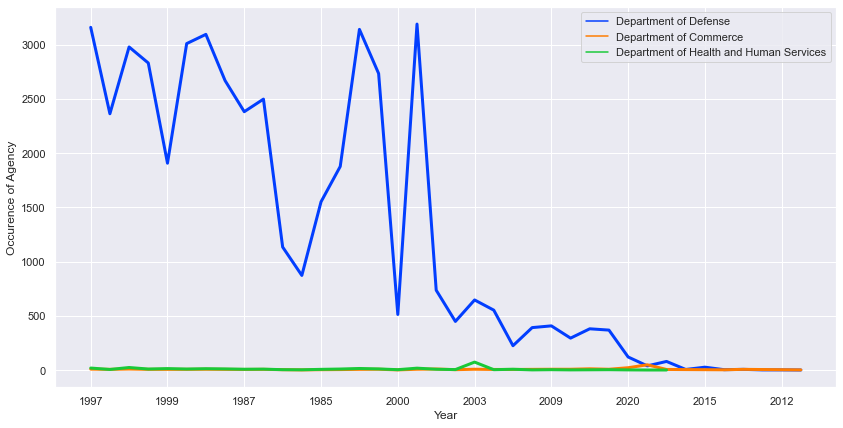

In [54]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,7)})

ax = sns.lineplot(data=year_wise_agency, x ='Year', y = 'Occurence', hue='Agency', palette='bright',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Occurence of Agency')
plt.xlabel('Year')
plt.show()

In [52]:
#year wise analysis of all the branches
request3 ="""
MATCH (b:branch)-[:AWARDED]-(c:company), (c:company)-[:AWARDED_IN]-(y:award_year)
WHERE b.name<>"NA"
RETURN distinct b.name AS branch, y.name AS year, count(*) as occurence;
""" 
year_wise_branch = pd.DataFrame(session.run(request3),columns=["Branch","Year","Occurence"])
print(year_wise_branch.head(5))

  Branch  Year  Occurence
0   Navy  1997        685
1   Navy  1988        567
2   Navy  1998        603
3   Navy  1991        618
4   Navy  1999        380


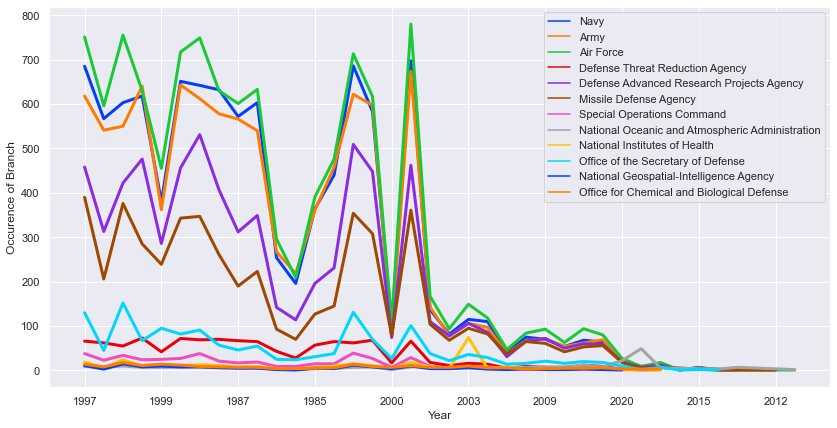

<Figure size 1008x504 with 0 Axes>

In [48]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,7)})

ax = sns.lineplot(data=year_wise_branch, x ='Year', y = 'Occurence', hue='Branch', palette='bright',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Occurence of Branch')
plt.xlabel('Year')
plt.show()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')